# Bayesian probability in pharmacokinetics

In [1]:
import numpy as np
import scipy
from scipy.integrate import odeint
from scipy import optimize, stats
import matplotlib.pyplot as plt
import math

In [2]:
# Parameters
k = 2
times = np.linspace(0,10,100)

# Bayesian sampling

In sampling, you measure the output of a system, and so estimate the parameters most likely to give that output. In this example we use a one-compartment model, which only has one parameter in the model.

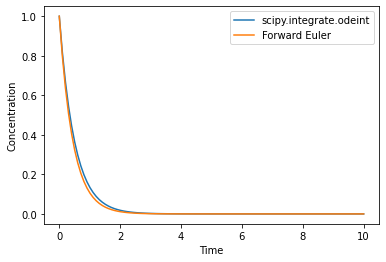

In [3]:
def onecomp(y, t, k):
    """A one-compartment PK model, aka simple exponential decay
    In
    y: y-axis value
    t: x-axis value
    k: gradient parameter
    
    Out: gradient at the given point
    """
    dydt = -k * y
    return dydt

# You can solve ODEs with scipy.integrate.odeint
def simulate(func, parameters, y0, times):
    """Numerically calculate an ODE
    In
    func: function giving the derivative
    parameters: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    return odeint(func, y0, times, (parameters,))

# or you could do the same thing without odeint by using forward euler
def ForwardEuler(func, k, y0, times):
    """Numerically calculate an ODE (forward Euler technique)
    In
    func: function giving the derivative
    k: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

# This is what the models look like, but we don't actually know these
ys = simulate(onecomp, k, 1, times)
actual_values = ForwardEuler(onecomp, k, 1, times)
values = ys.reshape((100,))

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values, label='scipy.integrate.odeint')
plt.plot(times, actual_values, label='Forward Euler')
plt.legend()
plt.show()

Without prior knowledge, we can make a guess at a model type that would give this kind of data, but we don't know what the parameters of the model are. We call these parameters theta ($\theta$) and in this single-compartment case the only parameter is k.

While we can estimate concentration (y(t)) at a given time (t) numerically by plotting from y(0), we have to guess a value of k. **We are trying to find the true value of k**.

You could measure from the system we're modelling, and you would get measurements with some measurement error, which we're modelling as gaussian noise below.

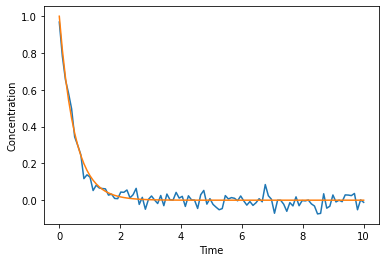

In [4]:
# Make noisy data that we're inferring from. noisy_data is known to us.
noisy_data = values + np.random.normal(0, 0.03, values.shape)
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, values)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [5]:
# So what do we want to minimise?
def sumofsquares(y_model, y_data):
    """Gives the sum of the square of all errors between model and experimental data.
    In
    y_model: list of output values from model
    y_data: list of experimental (i.e. noisy) values
    
    Out: the sum of square error
    """
    sq_error = []
    for t in range(len(y_model)):
        sq_error.append((y_data[t] - y_model[t])**2)
    
    return sum(sq_error)

In [6]:
# Optimise it with scipy
def scalar_to_minimise(parameters):
    """For a one compartment model & sum of squares this is what's minimised"""
    y_model = simulate(onecomp, parameters, 1, times)
    y_data = noisy_data
    return sumofsquares(y_model, y_data) / len(y_model)

start_params = 11
result = optimize.minimize_scalar(scalar_to_minimise)
print('Calculated k: '+str(result.x))

Calculated k: [2.0483544]


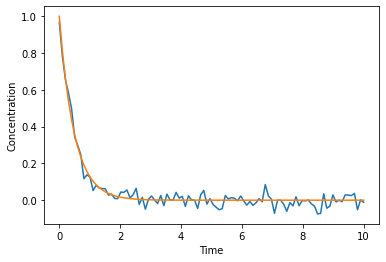

In [7]:
# What does that look like?
recon_model = simulate(onecomp, result.x, 1, times)
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, recon_model)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

Likelihood:

$Pr(y|k,sigma) = \prod_{i=1}^{N} 1/(2\pi\sigma^2) \text{exp}(-(y(t_i)-exp(-k t_i))^2/(2\sigma^2))$

Priors:

k ~ U(0, 10)  
sigma ~ U(0, 10)  
Pr(k) = 1/10, if k in [0, 10] or 0 otherwise  
Pr(sigma) = 1/10 ...  

$Pr(\theta|x) = \frac{Pr(X|\theta) Pr(\theta)}{Pr(X)}$

Pr(y|k,sigma) * Pr(k) * Pr(sigma)

# Metropolis sampling

Assuming that our only two inputs ($\theta$) are k (gradient scaling) and $\sigma$ (SD of noise)...

We want to find $Pr(\theta|X)$ (the posterior), which is a function giving the probability distribution for the model input parameters: that is, for each possible combination of input parameters, a likelihood that that is the combination producing this output. Input $\theta$ (vector, output probability density (scalar).

$Pr(\theta|X) = \frac{Pr(X|\theta) Pr(\theta)}{Pr(X)}$  
RHS has three parts: 
- $Pr(\theta)$: prior. Function that gives a probability density (scalar) from $\theta$ (vector). Here, gives 0.1 for all values of k & $\sigma$ between 0 and 10.
- $Pr(X|\theta)$: likelihood. It's just a crazy function that takes $\theta$ and gives a scalar. Accept and move on.
- $Pr(X)$: A number that normalises (makes the posterior integrate to 1).

**Steps**
1. Start with an arbitrary $\theta$ (a k and a $\sigma$). Calculate prior x likelihood.
2. Move to a different $\theta$ (+/- an amount from a normal distribution with SD given by the 'covariate matrix'). Calculate prior x likelihood.
3. If new prior x likelihood is higher than old, keep it and add the new $\theta$ to a list. If not, keep it if rand(0->1) > (old/new). If neither of these work, move back to the old one and add that instead.
4. Repeat steps 2-3 for N steps. 
5. Count your list of $\theta$s into bins and draw a histogram. This approximates your posterior.

In [8]:
# This gives a uniform prior theta ~ U(0,10) 

def uniform_prior(theta):
    """Returns 0.1 if entire input list is between 0 & 10, else 0"""

    prior = []
    for key, param in theta.items():
        if type(param) == list:
            print('DEBUG: THIS IS PARAM')
            print(param)
        if param > 0 and param < 10:
            prior.append(0.1)
        else:
            prior.append(0)
            
    return min(prior)


def likelihood(theta, y_model, y_data):
    k = theta['k']
    sigma = theta['s']
    exponential = -sumofsquares(y_model, y_data) / (2*sigma**2)
    
    return 1/(2*math.pi*sigma**2) * math.exp(exponential)

In [9]:
# This model stores all the model-related variables, so there's less weird passing of vars between functions

class OdeModel():
    
    def __init__(self, y_model, thetas, covariates, prior, likelihood):
        self.thetas = thetas
        self.covariates = covariates
        self.y = y_model
        self.prior = prior
        self.likelihood = likelihood
        self.log = {'zero':0, 'large':0, 'frac':0, 'allfracs':[], 'sumlogprob':[], 'fn_mean':[]}

        
thetas1 = [[{'k':1, 's':1}],
            [{'k':2, 's':2}],
            [{'k':5, 's':5}]]
covariates1 = {'k':0.05, 's':0.05}    
model = OdeModel(values, thetas1, covariates1, uniform_prior, likelihood)
# thetas = all thetas for all starting values
# thetas_onelot = a list of thetas from a single set of starting values = thetas[n]
# theta = one set of theta values, in a dict = thetas[n][m] = thetas_onelot[m]

In [10]:
def propose_new_theta(model, y_data, theta):

    numerator = model.prior(theta) * model.likelihood(theta, model.y, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = {}
    for key, value in theta.items():
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = model.prior(proposed_theta) * model.likelihood(proposed_theta, model.y, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta
    if proposed_numerator == 0:
        model.log['zero'] += 1
        pass
    elif proposed_numerator > numerator:
        theta = proposed_theta
        numerator = proposed_numerator
        model.log['large'] += 1
    elif np.random.rand() < proposed_numerator/numerator:
        model.log['frac'] += 1
        model.log['allfracs'].append(proposed_numerator/numerator)
        theta = proposed_theta
        numerator = proposed_numerator
    else:
        model.log['allfracs'].append(proposed_numerator/numerator)
    return theta

# Test that this works
start_theta = [1, 1]

result = propose_new_theta(model, noisy_data, {'k':1, 's':1})
print(result)

{'k': 0.9994017671351978, 's': 0.8717834974613002}


In [11]:
def metropolis_singlethread(model, y_data, threadnum, max_iters):
    iters = 0
    
    while iters < max_iters:
        theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
        model.thetas[threadnum].append(theta)
        iters = iters + 1

# test this works
model = OdeModel(values, thetas1, covariates1, uniform_prior, likelihood)
metropolis_singlethread(model, noisy_data, 0, 10)
print(model.thetas[0])

[{'k': 1, 's': 1}, {'k': 0.9554381358086713, 's': 0.845982957718393}, {'k': 0.954864498618664, 's': 0.823722437061038}, {'k': 0.8776956242168028, 's': 0.8888682235610424}, {'k': 0.9211033705111872, 's': 0.9418066570405337}, {'k': 0.9603103062944015, 's': 0.9890306722749381}, {'k': 0.9464484309780192, 's': 0.932467375192815}, {'k': 0.9497969023306526, 's': 0.9577347969900281}, {'k': 0.9806893416452503, 's': 0.9492165102273122}, {'k': 0.9537618386500254, 's': 0.9853288324077324}, {'k': 0.9278727076117939, 's': 0.9895180602030544}]


In [12]:
def metropolishastings(model, y_data, blocksize, number_of_blocks):
    n = 0
    while n < number_of_blocks:
        for threadnum, thetas_onelot in enumerate(model.thetas):
            metropolis_singlethread(model, y_data, threadnum, blocksize)
        n = n+1
        
# Does it work?
#model = OdeModel(values, thetas1, covariates1, uniform_prior, likelihood)
#metropolishastings(model, noisy_data, 500, 100)

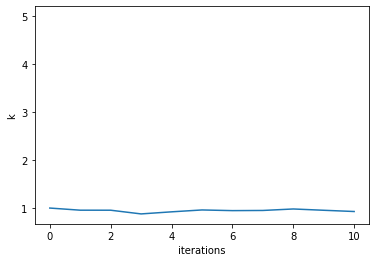

In [13]:
# what that looks like
plt.figure()
for n in range(len(model.thetas)):
    k = [theta['k'] for theta in model.thetas[n]]
    plt.plot(range(len(k)), k)
plt.xlabel('iterations')
plt.ylabel('k')
plt.show()

In [14]:

#TODO: Gelman Rubin convergence calculation.

print('%.3f & %.3f' % (2.3, 12/2))
model.log['zero'] +=1
#print(model.log)
sum(model.log['allfracs'])/len(model.log['allfracs'])

2.300 & 6.000


0.9249497236734109

In [15]:
# Hold s constant to see how the likelihood varies with k

def likelihood_s_constant(theta, y_model, y_data):
    k = theta['k']
    sigma = 0.03
    pdf = []
    y_model = ForwardEuler(onecomp, k, 1, times)
    other_bit = 1/(2*math.pi*sigma**2)
    for t in range(len(y_data)): # this loop gives a normally distributed pdf
        square_error = (y_data[t] - y_model[t])**2
        exponential = math.exp(-square_error/(2*sigma**2))
        pdf.append(exponential*other_bit)
    
    return np.prod(pdf)

thetas_k = [[{'k':5}]]
covariates_k = {'k':5}
model = OdeModel(values, thetas_k, covariates_k, uniform_prior, likelihood_s_constant)
metropolishastings(model, noisy_data, 100, 100)

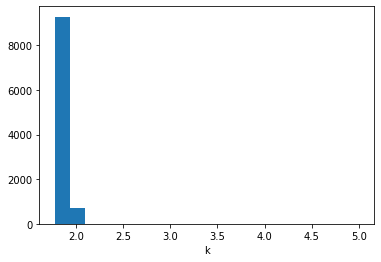

In [16]:
ks_list= [theta['k'] for theta in model.thetas[0]]
#print(model.log['fn_mean'][5])

plt.figure()
plt.hist(ks_list, bins=20)
plt.xlabel('k')
plt.show()

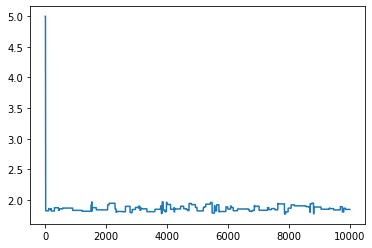

In [17]:
ks_list= [theta['k'] for theta in model.thetas[0]]
#print(model.log['fn_mean'][5])

plt.figure()
plt.plot(ks_list)
plt.show()

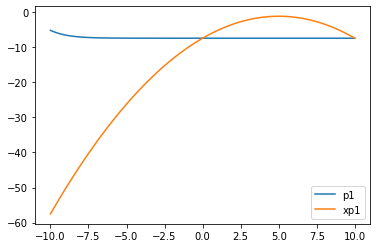

total values -738.636298109342 total x -1601.7195625168144


In [18]:
tester = 2
test = scipy.stats.norm.logpdf(values, loc=0, scale=3)


# Test we can at match a Gaussian distribution from scipy

mu = 5
var = 2
#dist = lk.Gaussian()

x = np.linspace(-10, 10, 100)

p1 = scipy.stats.norm.logpdf(values, loc=mu, scale=np.sqrt(var))
xp1 = scipy.stats.norm.logpdf(x, loc=mu, scale=np.sqrt(var))
plt.figure()
plot_p1 = plt.plot(x, p1, label='p1')
plot_xp1 = plt.plot(x, xp1, label='xp1')
plt.legend()
plt.show()
print('total values '+str(sum(p1))+' total x '+str(sum(xp1)))

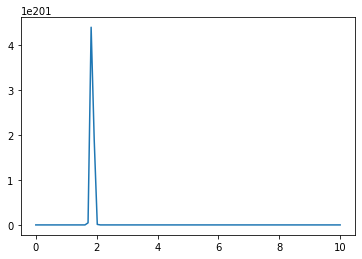

In [19]:
ks = np.linspace(0,10,100)
likelihoods = []
for k in ks:
    likelihoods.append(likelihood_s_constant({'k':k}, values, noisy_data))

plt.figure()
plt.plot(ks, likelihoods)
plt.show()

In [20]:
l = [1,2,3,4,5]
l[:-2]

[1, 2, 3]